In [35]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

#### Импорт данных

In [24]:
train = pd.read_csv("~/Applications/Solving-problems-from-courses/Stepik/Введение в соревновательный Data Science/Классические элементы анализа данных/data/car_train.csv")
test = pd.read_csv("~/Applications/Solving-problems-from-courses/Stepik/Введение в соревновательный Data Science/Классические элементы анализа данных/data/car_test.csv")

train.sample(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
40,y-3838245t,Kia Sportage,standart,petrol,4.70,2015,84786,2021,36.86,engine_overheat
1409,Z-6848638K,Smart Coupe,economy,petrol,4.32,2015,78524,2018,40.03,wheel_shake
194,i14933910A,Kia Rio X,economy,petrol,3.94,2015,81129,2018,47.30,engine_ignition


#### Базовый Feature engineering - генерируем и добавляем признаки

In [25]:
path = "~/Applications/Solving-problems-from-courses/Stepik/Введение в соревновательный Data Science/Классические элементы анализа данных/data/rides_info.csv"
rides = pd.read_csv(path)  # Данные по поездкам
rides.sample(3)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
436921,a21356995g,e89496897S,v1C,2020-01-04,4.61,64,571,47,81.000000,13,1101.728716,0,-5.476889,15.000
165556,C22397570E,L85244434f,D1C,2020-02-13,0.10,42,415,62,120.874806,1,2441.789907,0,1.419545,-0.509
276627,W90744562g,T-2633971l,F1D,2020-03-15,3.47,74,734,46,146.634371,0,1420.147729,0,-3.280051,22.339


In [26]:
# rides.hist(figsize=(15, 5), layout=(-1, 3))

In [27]:
f = lambda x: x.nunique()

rides_df_gr = rides.groupby("car_id", as_index=False).agg(
    mean_rating=("rating", "mean"),
    distance_sum=("distance", "sum"),
    rating_min=("rating", "min"),
    speed_max=("speed_max", "max"),
    user_ride_quality_median=("user_ride_quality", "median"),
    deviation_normal_count=("deviation_normal", "count"),
    user_uniq=("user_id", f))

rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [28]:
def add_featues(df):

    if "mean_rating" not in df.columns:
        return df.merge(rides_df_gr, on="car_id", how="left")

    return df

train = add_featues(train)
test = add_featues(test)

#### Закодируем категориальные признаки (`o-h-e`)

In [29]:
cat_features = ["car_type", "fuel_type", "model"]
train = pd.get_dummies(train, columns=cat_features)
test = pd.get_dummies(test, columns=cat_features)

train.head(4)

,car_id,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,...,model_Renault Sandero,model_Skoda Rapid,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4
0,y13744087j,3.78,2015,76163,2021,108.53,another_bug,4.737759,1.214131e+07,0.1,...,0,0,0,0,0,0,0,0,0,0
1,O41613818T,3.90,2015,78218,2021,35.20,electro_bug,4.480517,1.803909e+07,0.0,...,0,0,0,0,0,0,0,1,0,0
2,d-2109686j,6.30,2012,23340,2017,38.62,gear_stick,4.768391,1.588366e+07,0.1,...,1,0,0,0,0,0,0,0,0,0
3,u29695600e,4.04,2011,1263,2020,30.34,engine_fuel,3.880920,1.651883e+07,0.1,...,0,0,0,0,0,0,0,0,0,0


#### Классифицируем признаки

In [30]:
features2drop = ["car_id", "target_reg"]  # То, что можно выбросить
targets = ["target_class", "target_reg"]  # Таргеты
cat_features = ["car_type", "fuel_type", "model"]

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print("cat_features :", len(cat_features), cat_features)
print("num_features :", len(num_features), num_features)
print("targets", targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 43 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'car_type_business', 'car_type_economy', 'car_type_premium', 'car_type_standart', 'fuel_type_electro', 'fuel_type_petrol', 'model_Audi A3', 'model_Audi A4', 'model_Audi Q3', 'model_BMW 320i', 'model_Fiat 500', 'model_Hyundai Solaris', 'model_Kia Rio', 'model_Kia Rio X', 'model_Kia Rio X-line', 'model_Kia Sportage', 'model_MINI CooperSE', 'model_Mercedes-Benz E200', 'model_Mercedes-Benz GLC', 'model_Mini Cooper', 'model_Nissan Qashqai', 'model_Renault Kaptur', 'model_Renault Sandero', 'model_Skoda Rapid', 'model_Smart Coupe', 'model_Smart ForFour', 'model_Smart ForTwo', 'model_Tesla Model 3', 'model_VW Polo', 'model_VW Polo VI', 'model_VW Tiguan', 'model_Volkswagen ID.4 ']
targets ['target_class', 'target_reg']


#### Учим `Random Forest` с `K-fold` валидацией

In [33]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train[["target_class"]]

n_splits = 10
clfs = []
scores = []

# параметры валидации, обучение будет идти на n_splits (фолдах)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for num, (train_index, test_index) in enumerate(kf.split(X)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = RandomForestClassifier(
        n_estimators=2_000,
        min_samples_leaf=4,
        n_jobs=-1,
        max_features=0.60,
        # class_weight = 'balanced',
        random_state=7575,
        max_depth=6,
    )

    clfs.append(clf)  # Сохраняем модель для дальнейшего использования

    clf.fit(X_train, y_train["target_class"])

    y_pred = clf.predict(X_test)
    score = np.mean(np.array(y_pred == y_test["target_class"]))
    scores.append(score)
    print(f"fold: {num} acc: {score}")

assert len(clfs) == n_splits  # Проверка, что все ок

# Считаем среднее и дисперсию по всем фолдам
print("mean accuracy score --", np.mean(scores, dtype="float16"), np.std(scores).round(4))

fold: 0 acc: 0.8076923076923077
fold: 1 acc: 0.8034188034188035
fold: 2 acc: 0.8034188034188035
fold: 3 acc: 0.782051282051282
fold: 4 acc: 0.8589743589743589
fold: 5 acc: 0.8076923076923077
fold: 6 acc: 0.7735042735042735
fold: 7 acc: 0.7811158798283262
fold: 8 acc: 0.8068669527896996
fold: 9 acc: 0.7682403433476395
mean accuracy score -- 0.7993 0.0246


#### TODO-лист хорошей валидации    
    
* Фиксируем все `random_state`!
* Сохраняем модели всех фолдов, для инференса!
* Считаем не только среднее, но и дисперсию [если дисперсия высокая (в зависимости от задачи), то имеет место оверфит или утечка данных (`dataleak`)]
* Прикручиваем раннюю остановку `Early Stopping`
* Считаем кастомную метрику соревнования (особенно, если она комплексная)

#### Учим Random Forest со Stratified K-fold валидацией

In [34]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7575)

for train_index, test_index in kf.split(X=X, y=y["target_class"]):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # print(X_train.shape, y_train.shape)
    clf = RandomForestClassifier(
        n_estimators=2_000,
        min_samples_leaf=4,
        n_jobs=-1,
        max_features=0.60,
        random_state=7575,
        max_depth=6,
    )
    clfs.append(clf)

    clf.fit(X_train, y_train["target_class"])

    y_pred = clf.predict(X_test)
    score = np.mean(np.array(y_pred == y_test["target_class"]))
    scores.append(score)
    print(f"fold: acc: {score}")

assert len(clfs) == n_splits
print(
    "mean accuracy score --", np.mean(scores, dtype="float16"), np.std(scores).round(4)
)

fold: acc: 0.782051282051282
fold: acc: 0.7905982905982906
fold: acc: 0.8247863247863247
fold: acc: 0.8333333333333334
fold: acc: 0.811965811965812
fold: acc: 0.8076923076923077
fold: acc: 0.7948717948717948
fold: acc: 0.8025751072961373
fold: acc: 0.7982832618025751
fold: acc: 0.759656652360515
mean accuracy score -- 0.801 0.02


#### Построение Feature Importance

Всего признаков 43 Усреднее по 10-ти моделям: 
На график нанесено топ-43 признаков


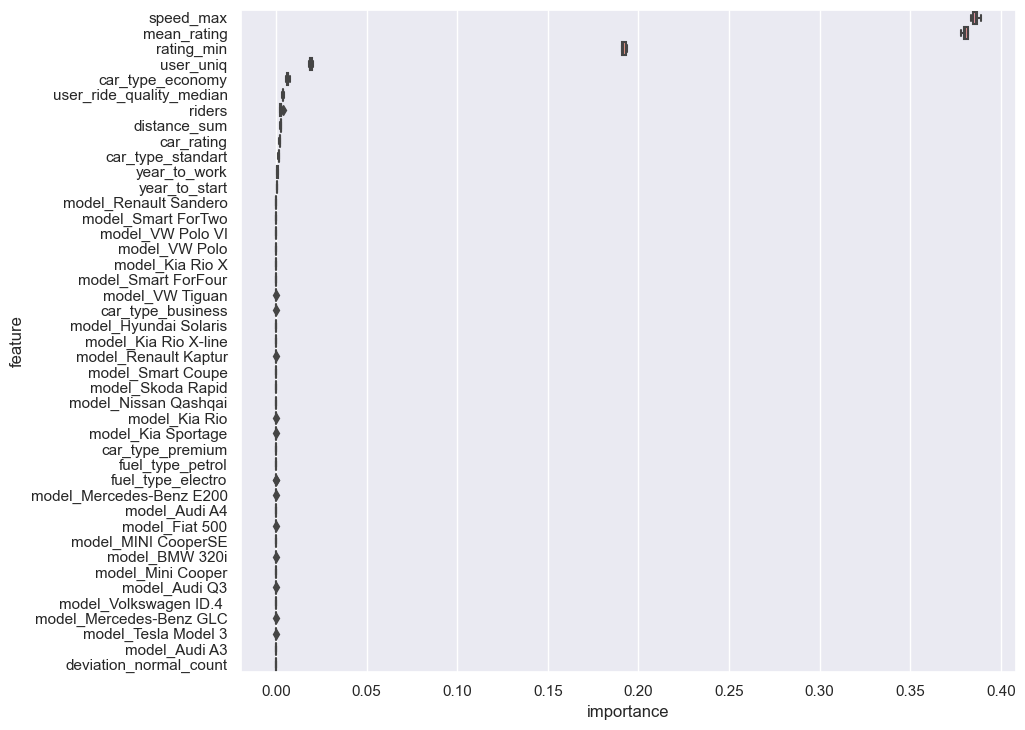

In [36]:
def plot_importance(df, best_model, height, top_n=50):

    top_n = min(top_n, df.shape[1])

    # Извлекаем значения из модели
    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.feature_importances_

    fi = fi.stack().reset_index().iloc[:, [0, 2]]
    fi.columns = ["feature", "importance"]

    # Определяем порядок признаков и отбираем только n признаков для отрисовки
    cols_ord = (
        fi.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()[:top_n]
    )

    fi = fi[fi["feature"].isin(cols_ord)]  # Выравниваем порядок по убыванию важности
    print( "Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))

    # Отрисовываем боксплоты фичей
    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False)
    )


df_feats_imp = plot_importance(
    train[filtered_features].drop(targets, axis=1, errors="ignore"),
    clfs,
    0.20,
    top_n=100,
)